Author: Chris J. Dallmann \
Affiliation: University of Wuerzburg \
Last revision: 16-July-2025

In [29]:
import pandas as pd
import numpy as np
from scipy.ndimage import uniform_filter1d
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

In [360]:
# Set parameters and load data
data_dir = r'Z:/Data/Roadrunner/'
dataset = 'arena_rr_sparc_cschrimson.csv'

sampling_rate = 20 # Hz
filter_size = 0.3 # s

color_ctrl = [0,0,0]
color_rr = [0/255, 174/255, 239/255]

# Load data
# Note: Positive angular velocity corresponds to counterclockwise turning
df = pd.read_csv(data_dir+dataset) 
df

,set,intensity,animal_id,frame,time,n_stimulus,x,y,forward_velocity,lateral_velocity,angular_velocity,speed
0,bilateral,9,1,1,0.05,0,71.1,40.2,0.000000,0.000000,0.000000,0.0
1,bilateral,9,1,2,0.10,0,71.1,40.2,0.000000,0.000000,-45.210038,0.0
2,bilateral,9,1,3,0.15,0,71.1,40.2,0.000000,0.000000,45.210038,0.0
3,bilateral,9,1,4,0.20,0,71.1,40.2,0.000000,0.000000,-15.696492,0.0
4,bilateral,9,1,5,0.25,0,71.1,40.2,-1.086503,-1.679140,0.000000,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...
455395,right,9,33,13796,689.80,0,55.5,85.8,-0.124035,0.992278,6.127832,1.0
455396,right,9,33,13797,689.85,0,55.5,85.9,0.000000,0.000000,0.000000,0.0
455397,right,9,33,13798,689.90,0,55.5,85.8,0.124035,-0.992278,0.000000,1.0
455398,right,9,33,13799,689.95,0,55.5,85.8,-0.124035,0.992278,0.000000,1.0


In [297]:
df.set.unique().tolist()

['bilateral', 'left', 'empty', 'right']

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


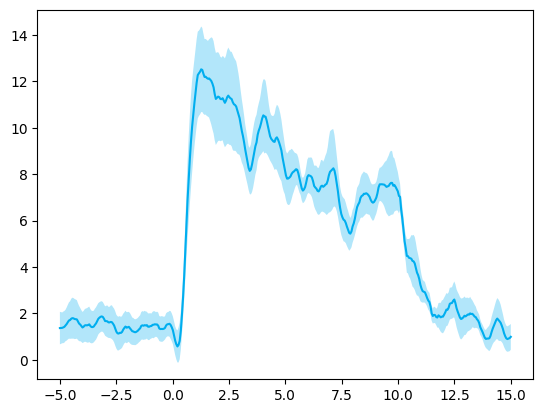

In [304]:
# Plot mean time course for a specific intensity
parameter_name = "forward_velocity" 
sets = ["bilateral"] 
intensity = 9
animal_sex = ['male']
stimulus_duration = 10 # s
pre_duration = 5 # s
post_duration = 5 # s

# Initialize variables
if 'sinusoidal' in dataset:
    df_sub = df[(df.animal_sex.isin(animal_sex))]
else:
    df_sub = df[(df.intensity==intensity) & (df.set.isin(sets))]

animal_ids = df_sub.animal_id.unique().tolist()
n_animals = len(animal_ids)
mean_parameters = np.zeros(((pre_duration+stimulus_duration+post_duration)*sampling_rate, len(animal_ids)))
mean_intensities = np.zeros(((pre_duration+stimulus_duration+post_duration)*sampling_rate, len(animal_ids)))

# Loop over animals
for animal_id_index, animal_id in enumerate(animal_ids):
    n_stimulus = df_sub.n_stimulus[df_sub.animal_id==animal_id].to_numpy()
    intensity = df_sub.intensity[df_sub.animal_id==animal_id].to_numpy()
    parameter = df_sub[parameter_name][df_sub.animal_id==animal_id].to_numpy()   

    # Flip angular velocity for set 'right'
    if parameter_name=='angular_velocity' and df_sub.set[df_sub.animal_id==animal_id].unique().item()=='right': 
        parameter = parameter*-1
    
    stimulus_onset_indices = np.argwhere(np.diff(n_stimulus)>0)+1
    
    mean_parameter = np.zeros(((pre_duration+stimulus_duration+post_duration)*sampling_rate, len(stimulus_onset_indices)))
    mean_intensity = np.zeros(((pre_duration+stimulus_duration+post_duration)*sampling_rate, len(stimulus_onset_indices))) 

    # Loop over stimulus presentations
    for index, _ in enumerate(stimulus_onset_indices):
        onset = stimulus_onset_indices[index][0]-pre_duration*sampling_rate
        offset = stimulus_onset_indices[index][0]+(stimulus_duration+post_duration)*sampling_rate
        
        mean_parameter[:,index] = uniform_filter1d(parameter[onset:offset], size=int(filter_size*sampling_rate))
        mean_intensity[:,index] = intensity[onset:offset]
        
    mean_parameters[:,animal_id_index] = np.nanmean(mean_parameter,axis=1) 
    mean_intensities[:,animal_id_index] = np.nanmean(mean_intensity,axis=1) 

# Plot mean time course
time = time = np.linspace(-pre_duration, stimulus_duration+post_duration, num=(pre_duration+stimulus_duration+post_duration)*sampling_rate)
mean = np.mean(mean_parameters,axis=1)
sem = np.std(mean_parameters,axis=1)/np.sqrt(np.size(mean_parameters,1))

if 'rr' in dataset:
    color = color_rr
else:
    color = color_ctrl
    
plt.plot(time, mean, color=color)
plt.fill_between(time, mean-sem, mean+sem, color=color, alpha=0.3, edgecolor='none')
#plt.ylim([-200,200])
plt.savefig(r'C:\Users\Chris\Desktop\figure.eps')
plt.show()

In [305]:
n_animals

5

In [361]:
def compute_mean_of_activation(df, parameter_name, filter_size):

    # Initialize variables 
    intensities = df.intensity.unique().tolist() 
    n_animals = int(len(df.animal_id.unique().tolist()) / len(intensities))
    
    mean_parameters = np.empty((n_animals,len(intensities)))
    mean_parameters[:] = np.nan
    
    # Loop over intensities
    for intensity_index, intensity in enumerate(intensities):
        animal_ids = df.animal_id[df.intensity==intensity].unique().tolist()
    
        # Loop over animals
        for animal_id_index, animal_id in enumerate(animal_ids):
            parameter = df[parameter_name][(df.animal_id==animal_id) & (df.n_stimulus!=0)].to_numpy()
            parameter = uniform_filter1d(parameter, size=int(filter_size))
    
            # Flip angular velocity for set 'right'
            if parameter_name=='angular_velocity' and df.set[df.animal_id==animal_id].unique().item()=='right': 
                parameter = parameter*-1
            
            parameter = np.mean(parameter)
    
            mean_parameters[animal_id_index,intensity_index] = parameter
        
    return mean_parameters

In [ ]:
# Plot mean of activation per animal and intensity for SPARC data

# ...

In [217]:
# Statistics

# # Shapiro Wilk test for normality
#_, p_value = stats.shapiro(mean_parameters[:,0])
#print(p_value)

# # Levenes test for equal variance
# _, p_value = stats.levene(mean_parameters[:,0], mean_parameters[:,1], mean_parameters[:,2], mean_parameters[:,3], mean_parameters[:,4])
# print(p_value)

# One-way ANOVA
# F(number of groups - 1, number of observations - number of groups)
f_statistic, p_value = stats.f_oneway(mean_parameters[:,0], mean_parameters[:,1], mean_parameters[:,2], mean_parameters[:,3], mean_parameters[:,4])
print(f_statistic)
print(p_value)

# Tukey's HSD test
res = stats.tukey_hsd(mean_parameters[:,0], mean_parameters[:,1], mean_parameters[:,2], mean_parameters[:,3], mean_parameters[:,4])
print(res)

49.55423345220635
2.7137649011794145e-28
Tukey's HSD Pairwise Group Comparisons (95.0% Confidence Interval)
Comparison  Statistic  p-value  Lower CI  Upper CI
 (0 - 1)     -2.879     0.000    -4.107    -1.650
 (0 - 2)     -4.309     0.000    -5.537    -3.080
 (0 - 3)     -4.981     0.000    -6.209    -3.752
 (0 - 4)     -5.560     0.000    -6.789    -4.332
 (1 - 0)      2.879     0.000     1.650     4.107
 (1 - 2)     -1.430     0.014    -2.659    -0.201
 (1 - 3)     -2.102     0.000    -3.331    -0.873
 (1 - 4)     -2.682     0.000    -3.911    -1.453
 (2 - 0)      4.309     0.000     3.080     5.537
 (2 - 1)      1.430     0.014     0.201     2.659
 (2 - 3)     -0.672     0.560    -1.901     0.557
 (2 - 4)     -1.252     0.044    -2.481    -0.023
 (3 - 0)      4.981     0.000     3.752     6.209
 (3 - 1)      2.102     0.000     0.873     3.331
 (3 - 2)      0.672     0.560    -0.557     1.901
 (3 - 4)     -0.580     0.692    -1.809     0.649
 (4 - 0)      5.560     0.000     4.332  

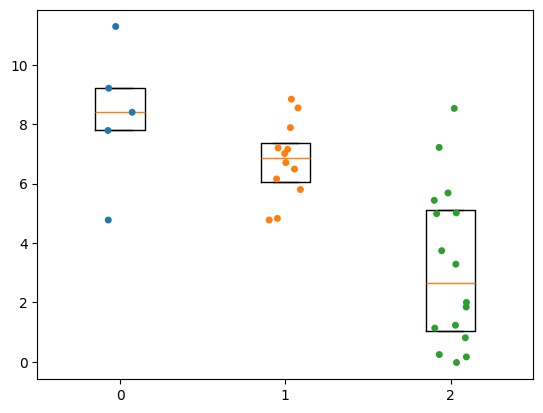

In [381]:
# Plot mean of activation per animal and intensity for SPARC data
parameter_name = "forward_velocity"

# Compute means
sets = ["bilateral"] 
df_sub = df[df.set.isin(sets)] 
means_bi = compute_mean_of_activation(df_sub, parameter_name, filter_size*sampling_rate)

sets = ["left","right"] 
df_sub = df[df.set.isin(sets)] 
means_uni = compute_mean_of_activation(df_sub, parameter_name, filter_size*sampling_rate)

sets = ["empty"] 
df_sub = df[df.set.isin(sets)] 
means_none = compute_mean_of_activation(df_sub, parameter_name, filter_size*sampling_rate)

# Plot means    
plt.boxplot([means_bi[:,0],means_uni[:,0],means_none[:,0]], positions=[0,1,2], showfliers=False, whis=0)
sns.stripplot([means_bi[:,0],means_uni[:,0],means_none[:,0]])
#plt.ylim([-2,15])
#plt.ylim([-200,200])
#plt.savefig(r'C:\Users\Chris\Desktop\figure.eps')
plt.show()

In [382]:
len(mean_parameters)

16

In [383]:
# Statistics

# Mann-Whitney U test for non-normally distributed (nonparametric) data
stats.mannwhitneyu(means_uni[:,0],means_none[:,0])

MannwhitneyuResult(statistic=np.float64(165.0), pvalue=np.float64(0.0014725845118836066))

In [216]:
np.size(mean_parameters,axis=0)

38

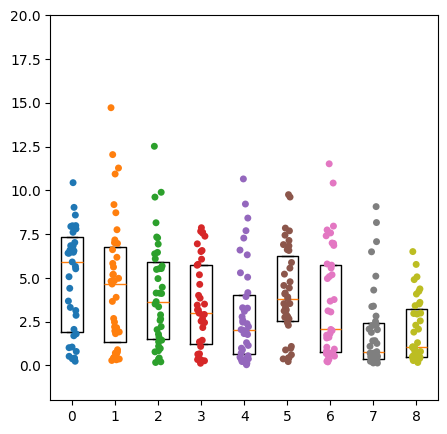

In [277]:
# Plot mean of time course per animal and repetition for a specific intensity
parameter_name = 'speed'
sets = [1,2] 
intensity = 1
stimulus_duration = 10 # s

# Initialize variables
df_sub = df[(df.intensity==intensity) & (df.set.isin(sets))]
animal_ids = df_sub.animal_id.unique().tolist()
n_animals = len(animal_ids)
n_stimulus_presentations = len(df_sub.n_stimulus[df_sub.n_stimulus!=0].unique().tolist())
mean_parameters = np.zeros((n_animals, n_stimulus_presentations))

# Loop over animals
for animal_id_index, animal_id in enumerate(animal_ids):
    n_stimulus = df_sub.n_stimulus[df_sub.animal_id==animal_id].to_numpy()
    parameter = df_sub[parameter_name][df_sub.animal_id==animal_id].to_numpy()
    stimulus_onset_indices = np.argwhere(np.diff(n_stimulus)>0)+1

    # Loop over stimulus presentations
    for index, _ in enumerate(stimulus_onset_indices):
        onset = stimulus_onset_indices[index][0]
        offset = stimulus_onset_indices[index][0]+stimulus_duration*sampling_rate
        mean_parameter = uniform_filter1d(parameter[onset:offset], size=int(filter_size*sampling_rate))
        mean_parameter = np.mean(mean_parameter)
        mean_parameters[animal_id_index,index] = mean_parameter

# Plot speed over stimulus repetitions
fig, ax = plt.subplots(figsize=(5, 5))
if 'rr' in dataset:
    color = color_rr
else:
    color = color_ctrl
    
plt.boxplot(mean_parameters, positions=(range(np.size(mean_parameters,1))), showfliers=False, whis=0)
sns.stripplot(mean_parameters)
ax.set_ylim(-2,20)
plt.savefig(r'C:\Users\Chris\Desktop\figure.eps')
plt.show()

In [29]:
n_animals

39

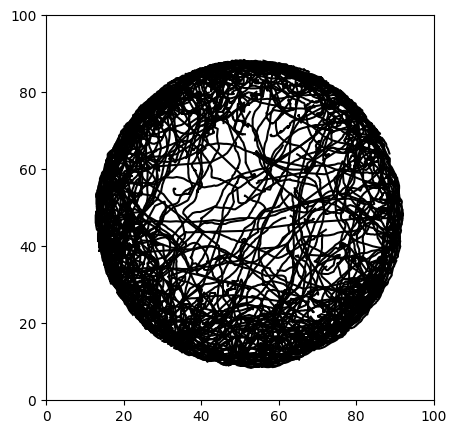

In [188]:
# Plot trajectories for a specific intensity 
# Note: Different sets can have different absolute x/y values. Plot separately.
intensity = 9
sets = [1,2]
subtract_origin = False
stimulus_duration = 10 # s

# Initialize variables
df_sub = df[(df.intensity==intensity) & (df.set.isin(sets))] 
animal_ids = df_sub.animal_id.unique().tolist()
fig, ax = plt.subplots(figsize=(5, 5))

# Loop over animals
for animal_id in animal_ids:
    #animal_id = animal_ids[25]
    x = df_sub["x"][(df_sub.animal_id==animal_id)].to_numpy() 
    y = df_sub["y"][(df_sub.animal_id==animal_id)].to_numpy() 
    n_stimulus = df_sub["n_stimulus"][(df_sub.animal_id==animal_id)].to_numpy() 
    stimulus_onset_indices = np.argwhere(np.diff(n_stimulus)>0)+1
    
    onset = stimulus_onset_indices[0][0]

    # Loop over stimulus presentations
    for index, _ in enumerate(stimulus_onset_indices):
        onset = stimulus_onset_indices[index][0]
        offset = onset+(stimulus_duration)*sampling_rate

        if subtract_origin:
            ax.plot(x[onset:offset]-x[onset], y[onset:offset]-y[onset], color=[0,0,0])
        else:
            ax.plot(x[onset:offset], y[onset:offset], color=[0,0,0])

if subtract_origin:
    lim = [-100,100]
else: 
    lim = [0,100]
    
ax.set_xlim(lim)
ax.set_ylim(lim)
# plt.savefig(r'C:\Users\Chris\Desktop\figure.eps')
plt.show()